# Entrenamiento: Autoencoder

Notebook para el entrenamiento del modelo "Cloud Top Height", cuyo trabajo es determinar la altura de las nubes en cada pixel.

Adrián Ramírez <br>
Contanto: felos@ciencias.unam.mx

### Preparando entorno

In [2]:
import os
import sys
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import trainconfig
sys.path.append(trainconfig.DIR_LIB)
sys.path.append(trainconfig.DIR_MODELOS)
import datasets
import modelos

import importlib
importlib.reload(datasets)
importlib.reload(modelos)
importlib.reload(trainconfig)

# Vemos si hay GPUs disponibles, y configuramos para que no use toda la memoria.
trainconfig.ver_gpus()

Name: /physical_device:GPU:0   Type: GPU


### Preparamos el dataset
**(Ver modulo trainconfig)** <br>

Entre las funciones que hace *trainconfig.preparar_dataset()* son: <br>
* Randomiza el orden de los datos
* Separa en train y test
* Normalización (max-min)


In [3]:
trainconfig.preparar_dataset_GAN()

Ya existen los datasets preparados,si desea volver a generarlos eliminelos y vulva a ejecutar la función.


### Preparando secuenciador

In [10]:
lista_keys_X = ["CTH","COD","CM"]
lista_keys_y = ["CTH","COD","CM"]

def callback_x(inputs):
    return (inputs*2 - 1) 

def callback_y(inputs):
    return (inputs*2 - 1) 
    
secuenciador = trainconfig.SecuenciaHDF5(
    X_keys = lista_keys_X,
    Y_keys = lista_keys_y,
    batch_size= trainconfig.BATCH_SIZE,
    path_dataset= trainconfig.PATH_DATASET_GAN,
    callback_x = callback_x,
    callback_y = callback_y,
)

### Importamos modelo

In [11]:
modelo = modelos.Modelo_Autoencoder(
    num_inputs = trainconfig.GAN_NOISE_DIM,
    path_pesos_decoder = f"{trainconfig.DIR_PESOS}/GAN_gen/pesos.tf"
)
modelo.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 37, 37, 3)]       0         
                                                                 
 modelo__encoder_3 (Modelo_E  (None, 50)               57330     
 ncoder)                                                         
                                                                 
 modelo_gan_generador_3 (Mod  (None, 37, 37, 3)        407193    
 elo_GAN_generador)                                              
                                                                 
Total params: 464,523
Trainable params: 57,106
Non-trainable params: 407,417
_________________________________________________________________


### Entrenamos modelo

Epoch 1/50
 15/379 [>.............................] - ETA: 2:08 - loss: 0.3954Entrenamiento interumpido.


NameError: name 'history' is not defined

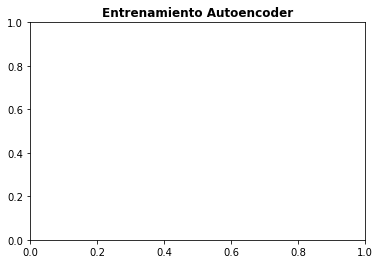

In [14]:
epochs = 50
learning_rate = 0.001

modelo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.MeanSquaredError(),
)

try:
    history = modelo.fit(
        secuenciador,
        epochs=epochs,
        shuffle=False,
        verbose=1,
    )
except KeyboardInterrupt:
    print("Entrenamiento interumpido.")
    

plt.title("Entrenamiento Autoencoder",weight="bold")
plt.plot(history.history["loss"],label="loss")
plt.xlabel("Epoca")
plt.ylabel("loss")
plt.grid()
plt.legend()

### Guardamos pesos

In [7]:
modelo.save_weights(f"{trainconfig.DIR_PESOS}/Autoencoder/pesos.tf",save_format="tf")
print(f"Pesos guardados en {trainconfig.DIR_PESOS}/Autoencoder/pesos.tf")

Pesos guardados en /home/felos/Repos/Deep-GOES/Modelos/Pesos//CTH/pesos.tf


## Inspección visual resultados

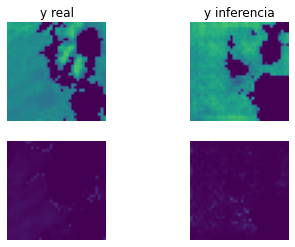

In [118]:
batch = 3
index = 152


x_prueba , y_real = secuenciador.__getitem__(batch)

y_inferencia = modelo(x_prueba).numpy()

fig,ax = plt.subplots(2,2)
for i in range(2):
    ax[0,i].axis("off")
    ax[1,i].axis("off")


ax[0,0].set_title("y real")
ax[0,1].set_title("y inferencia")

ax[0,0].imshow(y_real[index,:,:,0],vmin=-1,vmax=1,cmap="viridis")
ax[0,1].imshow(y_inferencia[index,:,:,0],vmin=-1,vmax=1,cmap="viridis")
ax[1,0].imshow(y_real[index,:,:,1],vmin=-1,vmax=1,cmap="viridis")
ax[1,1].imshow(y_inferencia[index,:,:,1],vmin=-1,vmax=1,cmap="viridis")


(array([1952.,   37.,    8.,    5.,    2.,  118.,  796.,  136.,    2.,
        1051.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

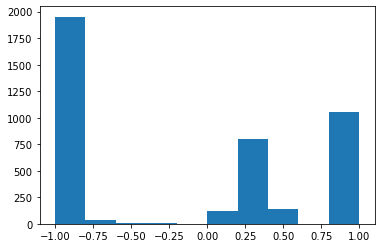

In [27]:
plt.hist(y_inferencia.reshape(-1))